SnowCV method to quantify snow height from phenocam staff gauge imagery.
For NEON Battelle
Donal O'Leary
April 12 2021

Borrowing liberally from <a href="https://www.pyimagesearch.com/2017/07/17/credit-card-ocr-with-opencv-and-python/" target="_blank">this awesome tutorial by Adrian Rosebrock</a>.

In [1]:
import cv2
import glob
import ntpath
import imutils
from imutils import contours
import argparse
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import numpy as np
import pandas as pd
from datetime import date
import datetime
%matplotlib inline

## Working with an Example Phenocam Image
For this next section, we will work with a single phenocam image to see if we can identify the digits that are on the staff gauge.

In [2]:
plt.rcParams['figure.figsize'] = [15, 15] # set plot size

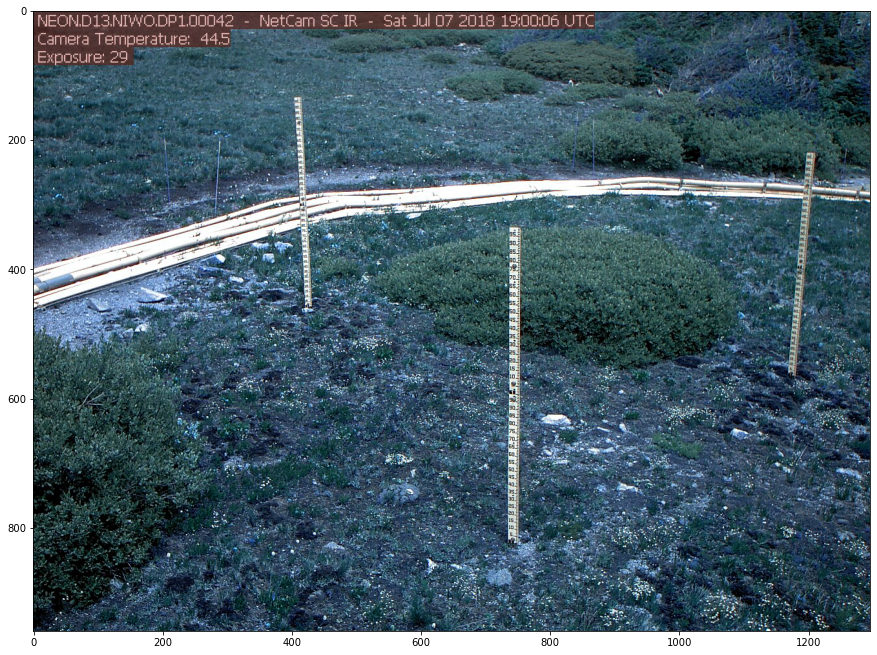

In [3]:
cal = cv2.imread('/Users/olearyd/Git/SnowCV/data/NIWO_gauge_calibration_bare_ground.jpg')
plt.imshow(cal)

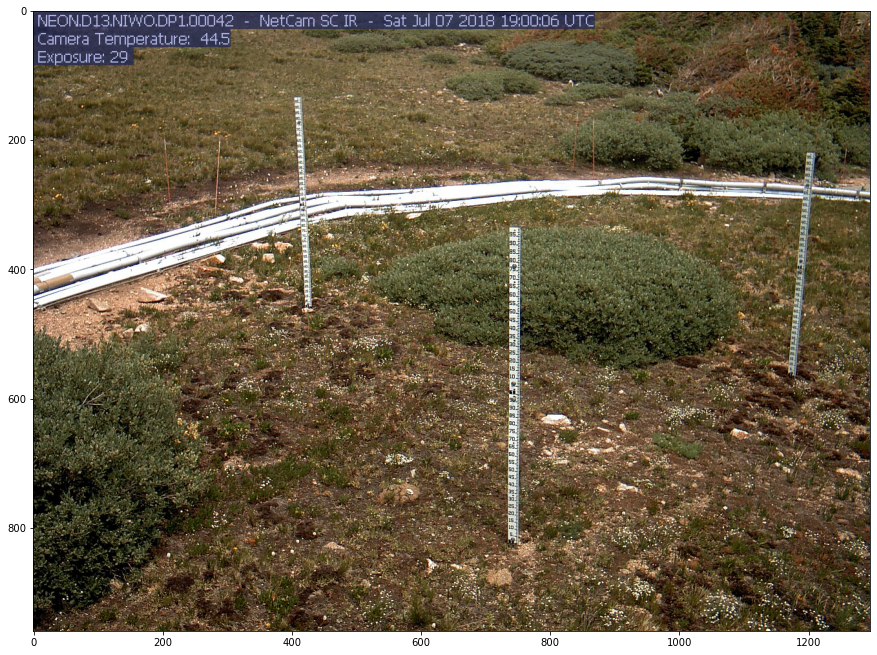

In [4]:
cal = cv2.cvtColor(cal, cv2.COLOR_BGR2RGB)
# Note that if you run this cell multiple times, it will keep reversing the colors! 
plt.imshow(cal)

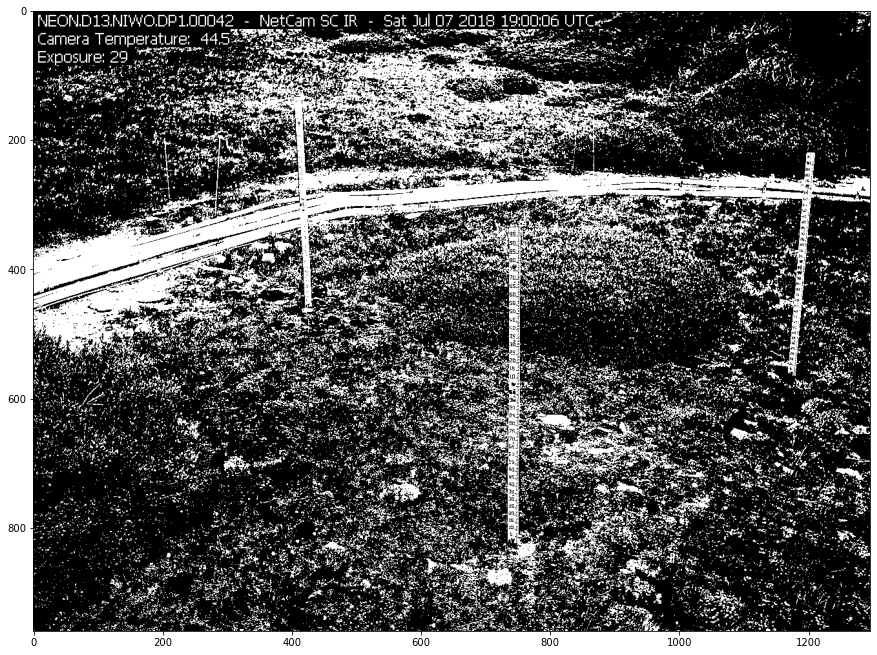

In [5]:
cal = cv2.cvtColor(cal, cv2.COLOR_RGB2GRAY)
cal = cv2.threshold(cal, 100, 255, cv2.THRESH_BINARY)[1]
plt.imshow(cal, cmap='gray')

Now we must make a very precise bounding box around the staff gauge - this will be our 'ground truth' staff gauge length representing of zero snow.

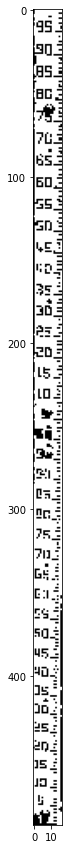

In [6]:
cal_gauge = cal[335:825,736:753]
plt.imshow(cal_gauge, cmap='gray')

In [7]:
gauge_height = cal_gauge.shape[0] # height in pixels
gauge_height

490

According to this image, the staff gauge has 490 visible pixels across its 2m height. We will use this to compare against subsequent images to deterrmine how deep the snow is!

## Working with a snowy Phenocam Image

In [8]:
## Update this to grob all files from direectory
fn = '/Users/olearyd/Git/SnowCV/data/NEON.D13.NIWO.DP1.00042_2017_05_09_150006.jpg'

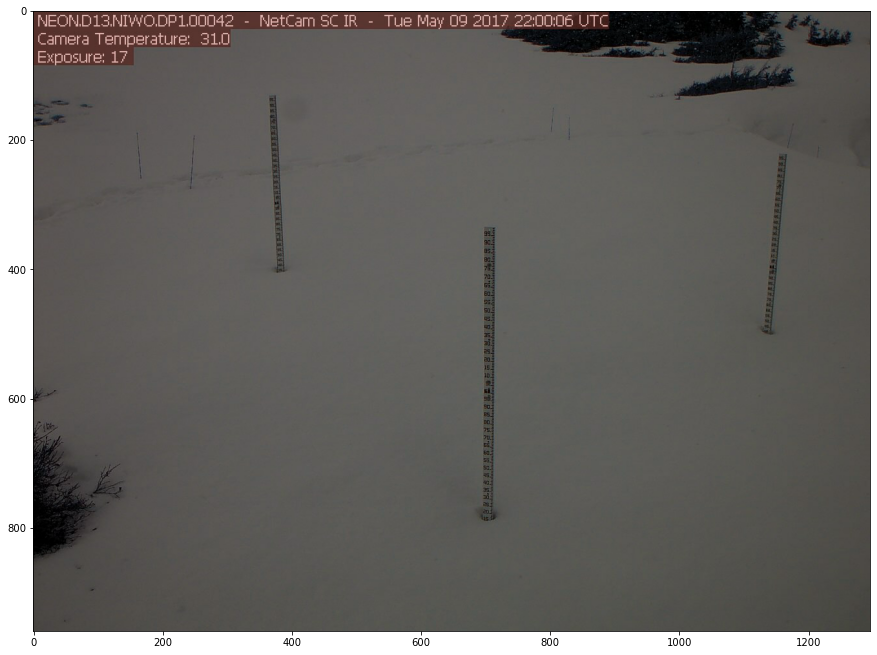

In [9]:
ref = cv2.imread(fn)
plt.rcParams['figure.figsize'] = [15, 15] # set plot size
plt.imshow(ref)

However, there is a problem here! The blue and red channels are reversed because `cv2.imread()` uses BGR as the default, whereas .jpg files are written in RGB order. So we can rearrange the channels and plot again.

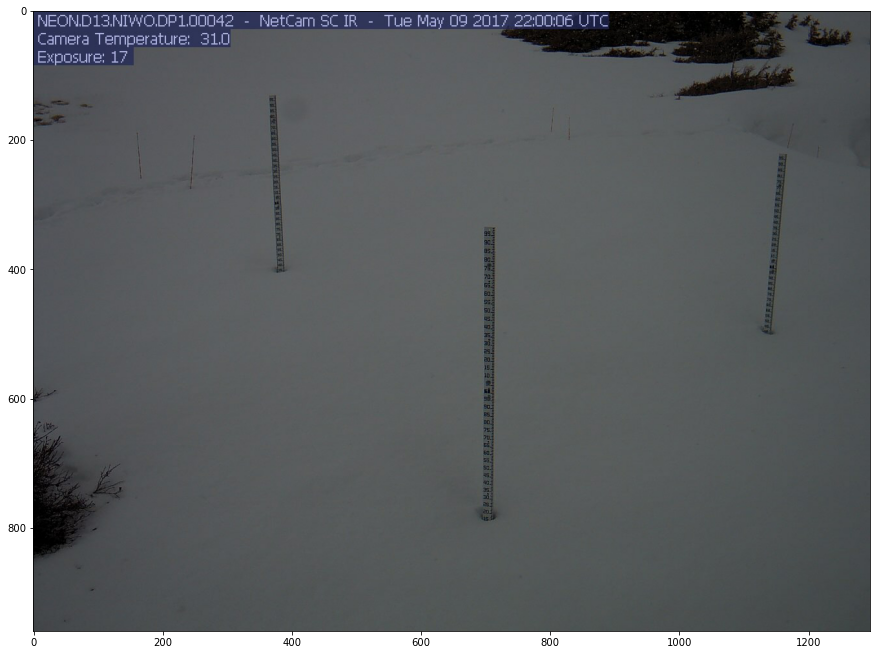

In [10]:
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
# Note that if you run this cell multiple times, it will keep reversing the colors! 
plt.imshow(ref)

In any case, it is best practice to convert the three-color-channel image to a grayscale image for further processing. So we will convert this RGB image to Gray using the `cv2.cvtColor()` function with the `cv2.COLOR_RGB2GRAY` argument.

In [11]:

ref = cv2.cvtColor(ref, cv2.COLOR_RGB2GRAY)
#ref = cv2.threshold(ref, 50, 255, cv2.THRESH_BINARY)[1]
ref = cv2.adaptiveThreshold(ref,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,25,2)
ref

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255,   0, ..., 255, 255, 255],
       ...,
       [  0, 255, 255, ..., 255, 255, 255],
       [  0, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

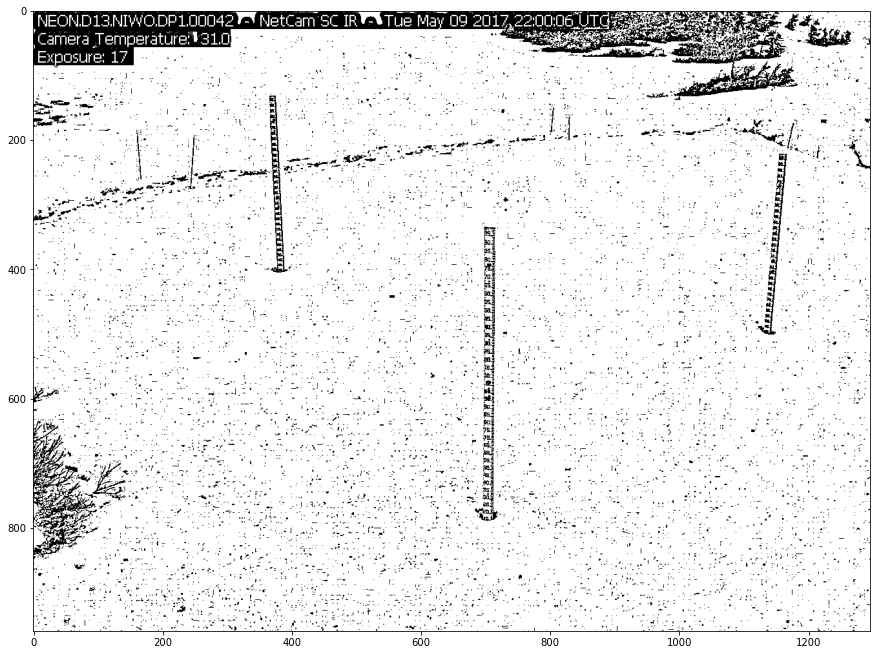

In [12]:
plt.imshow(ref, cmap='gray')

In [13]:
#ROI = ref[335:825,735:755]
ROI = ref[335:825,690:715]

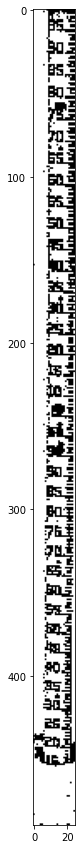

In [14]:
#plt.rcParams['figure.figsize'] = [5, 15]
plt.imshow(ROI,cmap='gray')

Now, let's see if we can blur the image into a single bar and measure its length

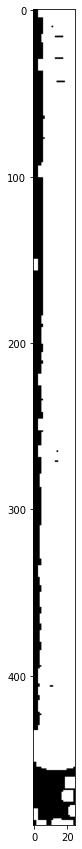

In [15]:
kernel = np.ones((5,5),np.uint8)
ROI_bar = cv2.Canny(ROI.copy() , 10, 255)
ROI_bar = cv2.dilate(ROI_bar, kernel, iterations = 1)
#ROI_bar = cv2.erode(ROI_bar, kernel, iterations = 5)
#ROI_bar = ROI.copy()
plt.imshow(ROI_bar,cmap='gray')

In [16]:
templateCnts = cv2.findContours(ROI_bar.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
templateCnts = imutils.grab_contours(templateCnts)
templateCnts = contours.sort_contours(templateCnts, method="left-to-right")[0]

In [17]:
len(templateCnts)

7

In [18]:
bb_heights = []
for (i, c) in enumerate(templateCnts):
    # compute the bounding box for the digit, extract it, and resize
    # it to a fixed size
    (x, y, w, h) = cv2.boundingRect(c)
    bb_heights.append(h)

visible_gauge = max(bb_heights)
print(visible_gauge)

457


Now that we have a length of the visible staff gauge text and markers, we can subtract that length from the total length of the staff gauge with no snow present, and divide by the number of pixels per meter to find meters of snow!

In [19]:
(gauge_height - visible_gauge)/gauge_height*200

13.46938775510204

## Phenocam Movement
Unfortunately, this phenocam at NIWO has moved some over time. On October 08, 2019, at approximately 12:05 Colorado time, the phenocam was moved slightly, which means that we must change the ROI for the gaguge after this point.

Another issue is that one of the instrument booms was in the field of view for the phenocam prior to May 9, 2017, which obscures the bottom of the staff gauge.

For now, let's just look at data between those two dates.

In [20]:
files = sorted(glob.glob('/Users/olearyd/Downloads/phenocamdata_8/NEON.D13.NIWO.DP1.00042/**/*.jpg', recursive=True))
files

['/Users/olearyd/Downloads/phenocamdata_8/NEON.D13.NIWO.DP1.00042/2017/05/NEON.D13.NIWO.DP1.00042_2017_05_09_120006.jpg',
 '/Users/olearyd/Downloads/phenocamdata_8/NEON.D13.NIWO.DP1.00042/2017/05/NEON.D13.NIWO.DP1.00042_2017_05_10_120005.jpg',
 '/Users/olearyd/Downloads/phenocamdata_8/NEON.D13.NIWO.DP1.00042/2017/05/NEON.D13.NIWO.DP1.00042_2017_05_11_120006.jpg',
 '/Users/olearyd/Downloads/phenocamdata_8/NEON.D13.NIWO.DP1.00042/2017/05/NEON.D13.NIWO.DP1.00042_2017_05_12_120006.jpg',
 '/Users/olearyd/Downloads/phenocamdata_8/NEON.D13.NIWO.DP1.00042/2017/05/NEON.D13.NIWO.DP1.00042_2017_05_13_120006.jpg',
 '/Users/olearyd/Downloads/phenocamdata_8/NEON.D13.NIWO.DP1.00042/2017/05/NEON.D13.NIWO.DP1.00042_2017_05_14_120006.jpg',
 '/Users/olearyd/Downloads/phenocamdata_8/NEON.D13.NIWO.DP1.00042/2017/05/NEON.D13.NIWO.DP1.00042_2017_05_15_120006.jpg',
 '/Users/olearyd/Downloads/phenocamdata_8/NEON.D13.NIWO.DP1.00042/2017/05/NEON.D13.NIWO.DP1.00042_2017_05_16_120006.jpg',
 '/Users/olearyd/Downloa

In [21]:
for f in range(len(files)):
    bn = ntpath.basename(files[f])
    l = bn.split('_')
    print(l[1] +','+ l[2] +','+ l[3]+','+l[4][0:6])
    #print(ntpath.basename(files[f]))

2017,05,09,120006
2017,05,10,120005
2017,05,11,120006
2017,05,12,120006
2017,05,13,120006
2017,05,14,120006
2017,05,15,120006
2017,05,16,120006
2017,05,17,120006
2017,05,18,120006
2017,05,19,120006
2017,05,20,120006
2017,05,21,120006
2017,05,22,120006
2017,05,23,120006
2017,05,24,120007
2017,05,25,120005
2017,05,26,120006
2017,05,27,120006
2017,05,28,120006
2017,05,29,120006
2017,05,30,120006
2017,05,31,120006
2017,06,01,120006
2017,06,02,120006
2017,06,03,120005
2017,06,04,120006
2017,06,05,120006
2017,06,06,120006
2017,06,07,120006
2017,06,08,120006
2017,06,09,120006
2017,06,10,120006
2017,06,11,120006
2017,06,12,120006
2017,06,13,120006
2017,06,14,120005
2017,06,15,120006
2017,06,16,120006
2017,06,17,120006
2017,06,18,120006
2017,06,19,120006
2017,06,20,120006
2017,06,21,120006
2017,06,22,120005
2017,06,23,120006
2017,06,24,120006
2017,06,25,120006
2017,06,26,120006
2017,06,27,120006
2017,06,28,120006
2017,06,29,120006
2017,06,30,120006
2017,07,01,120006
2017,07,02,120006
2017,07,03

In [22]:
def snow_depth_from_img(img, g_height):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,25,10)
    #img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)[1]
    #img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,25,2)
    img_ROI = img[335:825,675:780]
    #img_ROI = img[330:830,675:730] # What if we make the ROI larger
    kernel = np.ones((5,5),np.uint8)
    img_ROI_bar = cv2.Canny(img_ROI.copy() , 10, 255)
    img_ROI_bar = cv2.dilate(img_ROI_bar, kernel, iterations = 2)
    img_ROI_bar = cv2.erode(img_ROI_bar, kernel, iterations = 2)
    
    # Get contours of shape
    img_Cnts = cv2.findContours(img_ROI_bar.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_Cnts = imutils.grab_contours(img_Cnts)
    
    # There may be multiple contours due to noise or a smudge on the gauge, 
    # so find the height of the tallest one to compare against gauge height
    img_bb_heights = []
    for (i, c) in enumerate(img_Cnts):
        # compute the bounding box for the digit, extract it, and resize
        # it to a fixed size
        (x, y, w, h) = cv2.boundingRect(c)
        img_bb_heights.append(h)

    if len(img_bb_heights)==0:
        visible_gauge = 9999
    else:
        visible_gauge = max(img_bb_heights)
    
    # Calculate depth of snow
    DOS = (g_height - visible_gauge)/g_height*200
    
    return DOS


In [23]:
snow_depth_from_img(files[0], gauge_height)
# Should be about 14cm

15.510204081632653

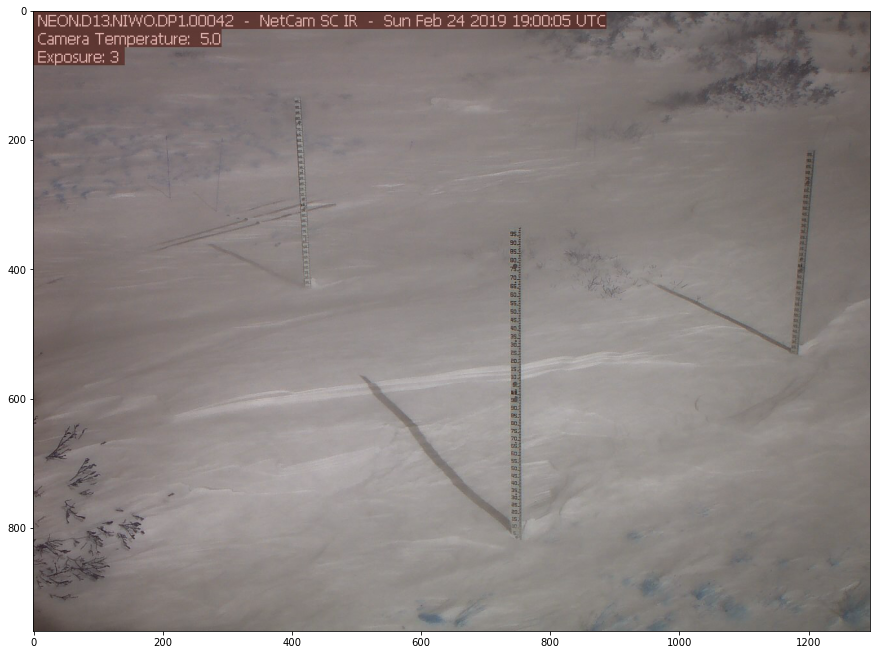

In [24]:
plt.imshow(cv2.imread(files[616]))

In [25]:
## Depth of Snow for all images
df = pd.DataFrame(columns=['img_number', 'year', 'month','day','time','snow_depth'])
for f in range(len(files)):
    bn = ntpath.basename(files[f])
    l = bn.split('_')
    d = snow_depth_from_img(files[f], gauge_height)
    row = [f,int(l[1]),int(l[2]),int(l[3]),int(l[4][0:6]),d]
    df.loc[f]=row
    #print(row)

In [26]:
#df['date']=date(df.year.astype(str).astype(int)) #, df.month.astype(str).astype(int), df.day.astype(str).astype(int)
#df['date']=date(df.year.astype(int), df.month.astype(int), df.day.astype(int))
#df.dtypes
#df.year.astype(int)
#df = df.astype({"img_number":int ,"year": int, "month": int, "day": int, "time": int})
sd = df.snow_depth
df = df.astype(int)
df.dtypes
#df['date']= df.apply(lambda x:datetime.datetime.strptime("{0} {1} {2}".format(x['year'],x['month'], x['day']), "%Y %m %d"),axis=1)
#df.index= df['date']

img_number    int64
year          int64
month         int64
day           int64
time          int64
snow_depth    int64
dtype: object

In [27]:
df['date']= df.apply(lambda df: datetime.date(df['year'], df['month'], df['day']), axis=1)
#df.dtypes
#df['date']= df.apply(lambda x:datetime.datetime.strptime("{0} {1} {2}".format(x['year'],x['month'], x['day']), "%Y %m %d"),axis=1)
#df['date']= df.apply(lambda x:datetime.datetime.strptime("{x['year']:.0f} {x['month']:2.0f} {x['day']:2.0f}", "%Y %m %d"),axis=1)
df.snow_depth = sd


In [28]:
pd.set_option('display.max_rows', 1000)
df

img_number  year  month  day    time   snow_depth        date
0             0  2017      5    9  120006    15.510204  2017-05-09
1             1  2017      5   10  120005    16.734694  2017-05-10
2             2  2017      5   11  120006    15.918367  2017-05-11
3             3  2017      5   12  120006    11.428571  2017-05-12
4             4  2017      5   13  120006     5.714286  2017-05-13
5             5  2017      5   14  120006     0.000000  2017-05-14
6             6  2017      5   15  120006     0.000000  2017-05-15
7             7  2017      5   16  120006     0.000000  2017-05-16
8             8  2017      5   17  120006     0.000000  2017-05-17
9             9  2017      5   18  120006    54.285714  2017-05-18
10           10  2017      5   19  120006    65.306122  2017-05-19
11           11  2017      5   20  120006    58.367347  2017-05-20
12           12  2017      5   21  120006    55.102041  2017-05-21
13           13  2017      5   22  120006    51.428571  2017-05-22
14           14  2017      5   23  120006    49.387755  2017-05-23
15           15  2017      5   24  120007    29.795918  2017-05-24
16           16  2017      5   25  120005    31.428571  2017-05-25
17           17  2017      5   26  120006    40.000000  2017-05-26
18           18  2017      5   27  120006    37.142857  2017-05-27
19           19  2017      5   28  120006    35.918367  2017-05-28
20           20  2017      5   29  120006    33.469388  2017-05-29
21           21  2017      5   30  120006    16.326531  2017-05-30
22           22  2017      5   31  120006    20.816327  2017-05-31
23           23  2017      6    1  120006    14.285714  2017-06-01
24           24  2017      6    2  120006     6.938776  2017-06-02
25           25  2017      6    3  120005     0.000000  2017-06-03
26           26  2017      6    4  120006     0.000000  2017-06-04
27           27  2017      6    5  120006     0.000000  2017-06-05
28           28  2017      6    6  120006     0.000000  2017-06-06
29           29  2017      6    7  120006     0.000000  2017-06-07
30           30  2017      6    8  120006     0.000000  2017-06-08
31           31  2017      6    9  120006     0.000000  2017-06-09
32           32  2017      6   10  120006     0.000000  2017-06-10
33           33  2017      6   11  120006     0.000000  2017-06-11
34           34  2017      6   12  120006     0.000000  2017-06-12
35           35  2017      6   13  120006     0.000000  2017-06-13
36           36  2017      6   14  120005     0.000000  2017-06-14
37           37  2017      6   15  120006     0.000000  2017-06-15
38           38  2017      6   16  120006     0.000000  2017-06-16
39           39  2017      6   17  120006     0.000000  2017-06-17
40           40  2017      6   18  120006     0.000000  2017-06-18
41           41  2017      6   19  120006     0.000000  2017-06-19
42           42  2017      6   20  120006     0.000000  2017-06-20
43           43  2017      6   21  120006     0.000000  2017-06-21
44           44  2017      6   22  120005     0.000000  2017-06-22
45           45  2017      6   23  120006     0.000000  2017-06-23
46           46  2017      6   24  120006     0.000000  2017-06-24
47           47  2017      6   25  120006     0.000000  2017-06-25
48           48  2017      6   26  120006     0.000000  2017-06-26
49           49  2017      6   27  120006     0.000000  2017-06-27
50           50  2017      6   28  120006     0.000000  2017-06-28
51           51  2017      6   29  120006     0.000000  2017-06-29
52           52  2017      6   30  120006     0.000000  2017-06-30
53           53  2017      7    1  120006     0.000000  2017-07-01
54           54  2017      7    2  120006     0.000000  2017-07-02
55           55  2017      7    3  120005     0.000000  2017-07-03
56           56  2017      7    4  120006     0.000000  2017-07-04
57           57  2017      7    5  120006     0.000000  2017-07-05
58           58  2017      7    6  120006     0.0000

In [29]:
df=df[df['snow_depth'] >= 0]
#df=df[df['snow_depth'] <= 70]

<AxesSubplot:xlabel='date'>

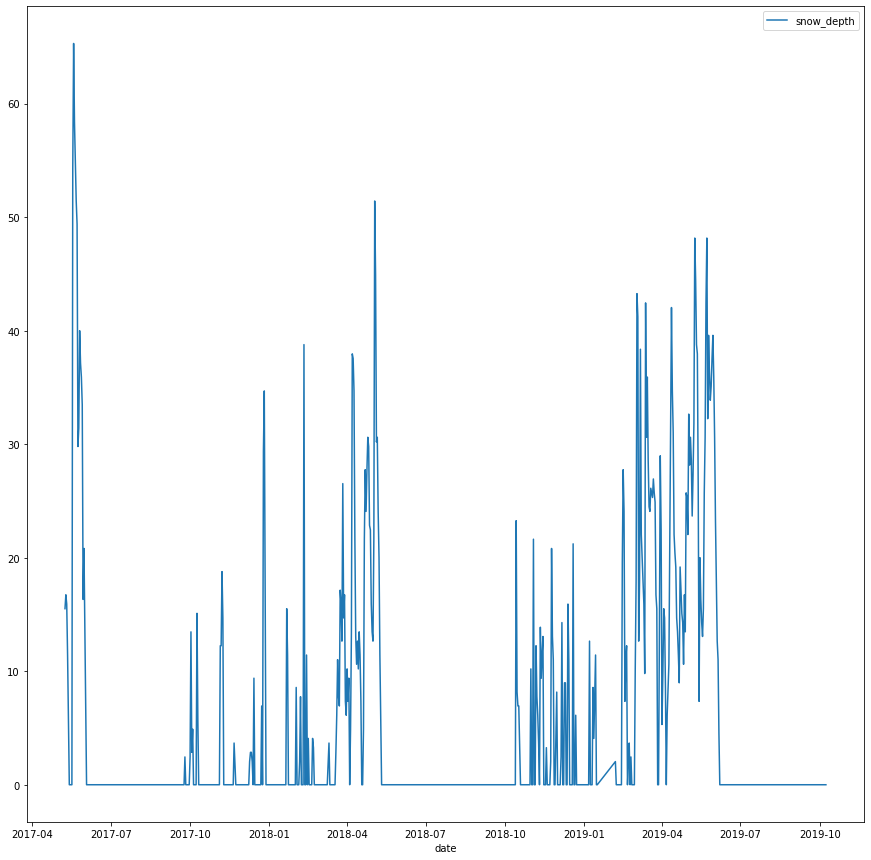

In [30]:
df.plot(x="date", y="snow_depth")

In [100]:
def check_img(number):
    plt.rcParams['figure.figsize'] = [15, 15] # set plot size
    figure, ax = plt.subplots(3,figsize=(15,15))
    #print(figure)
    img = cv2.imread(files[number])
    rect = matplotlib.patches.Rectangle((690,335),(780-675),(825-335), edgecolor='r', facecolor="none")
    ax[0].imshow(img)
    ax[0].add_patch(rect)
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #img = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)[1]
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,25,10)
    #[335:825,690:715]
    rect = matplotlib.patches.Rectangle((690,335),(780-675),(825-335), edgecolor='r', facecolor="none")

    
    # Plot CV process
    kernel = np.ones((5,5),np.uint8)
    img_ROI = img[335:825,675:780]
    img_ROI_bar = cv2.Canny(img_ROI.copy() , 10, 255)
    img_ROI_bar = cv2.dilate(img_ROI_bar, kernel, iterations = 2)
    img_ROI_bar = cv2.erode(img_ROI_bar, kernel, iterations = 2)
    #print(type(img_ROI_bar))
    
    #figure2, ax2 = plt.subplots(2)    
    
    # Get contours of shape
    img_Cnts = cv2.findContours(img_ROI_bar.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_Cnts = imutils.grab_contours(img_Cnts)
    
    # There may be multiple contours due to noise or a smudge on the gauge, 
    # so find the height of the tallest one to compare against gauge height
    #img_bb_heights = []
    for (i, c) in enumerate(img_Cnts):
        # compute the bounding box for the digit, extract it, and resize
        # it to a fixed size
        (x, y, w, h) = cv2.boundingRect(c)
        #img_bb_heights.append(h)
        rect2 = matplotlib.patches.Rectangle((x,y),w,h, edgecolor='g', facecolor="none", linewidth = 2)
        rect2_adj = matplotlib.patches.Rectangle((x+675,y+335),w,h, edgecolor='g', facecolor="none", linewidth = 2)

    # plot the grayscale image with search window and visible gauge rectangles
    
    patches = []
    patches.append(rect)
    patches.append(rect2_adj)
    ax[1].imshow(img, cmap='gray')
    ax[1].add_collection(matplotlib.collections.PatchCollection(patches, match_original=True))
    #ax[1].add_patch(rect2)
    
    # plot the visible staff gauge as found by the algorithm
    ax[2].imshow(img_ROI_bar, cmap='gray')
    ax[2].add_patch(rect2)

#     if len(img_bb_heights)==0:
#         visible_gauge = 9999
#     else:
#         visible_gauge = max(img_bb_heights)
    
    return 

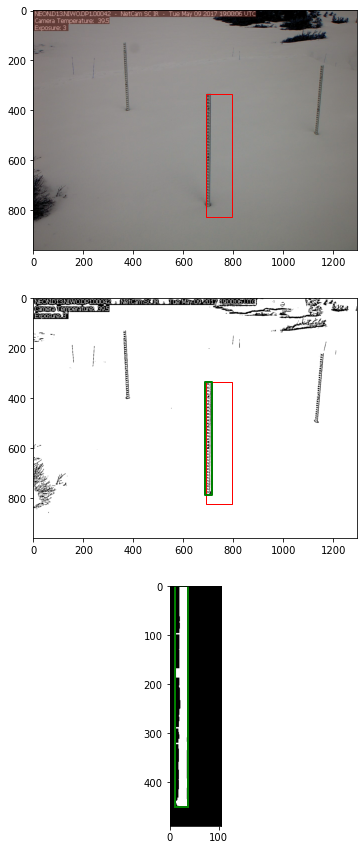

In [101]:
check_img(0)

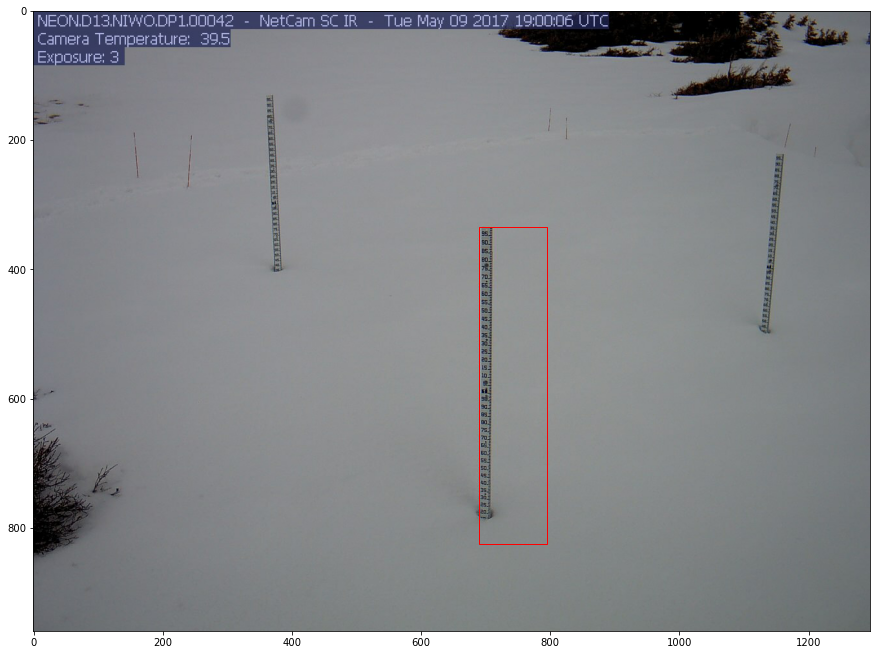

In [80]:

plt.rcParams['figure.figsize'] = [15, 15] # set plot size
img = matplotlib.image.imread(files[0])

figure, ax = plt.subplots(1)

#[335:825,690:715]
rect = matplotlib.patches.Rectangle((690,335),(780-675),(825-335), edgecolor='r', facecolor="none")

ax.imshow(img)


ax.add_patch(rect)